In [162]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import RFECV 

from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from tensorflow.keras import layers

In [163]:
train_df = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [164]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,49999.500000,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,28867.657797,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,24999.750000,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,49999.500000,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,74999.250000,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,99999.000000,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


In [165]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Pclass       100000 non-null  int64  
 2   Name         100000 non-null  object 
 3   Sex          100000 non-null  object 
 4   Age          96513 non-null   float64
 5   SibSp        100000 non-null  int64  
 6   Parch        100000 non-null  int64  
 7   Ticket       94819 non-null   object 
 8   Fare         99867 non-null   float64
 9   Cabin        29169 non-null   object 
 10  Embarked     99723 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 8.4+ MB


- 5/12 columns missing values
- 5/12 columns need type conversion
- 42% Survived., so accuracy will be a reasonable metric to evaluate our model.
- Survived is target
- PassengerId is just incremental index, it does not convery any information
- Too many value missings in Cabin, may we omit this field ?

# Data Visualization

In [166]:
train_df['Pclass'].value_counts()

3    41006
1    30315
2    28679
Name: Pclass, dtype: int64

In [167]:
train_df['Sex'].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

In [168]:
train_df['Cabin'].value_counts()

C19828    6
C6906     5
C13699    5
C14534    5
C19623    5
         ..
D5114     1
C14576    1
A13402    1
D13621    1
B20678    1
Name: Cabin, Length: 26992, dtype: int64

In [169]:
train_df['Embarked'].value_counts()

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64

In [170]:
train_df['Ticket'].value_counts()

A/5            602
C.A.           177
SC/PARIS       145
SOTON/O.Q.      80
SC              57
              ... 
C 443224         1
PC 458443        1
61276            1
208735           1
A/5. 5893        1
Name: Ticket, Length: 75331, dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Count'>

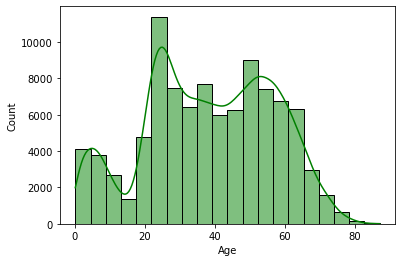

In [171]:
sns.histplot(x=train_df['Age'], bins=20, kde=True, color='g')

<AxesSubplot:xlabel='Fare', ylabel='Count'>

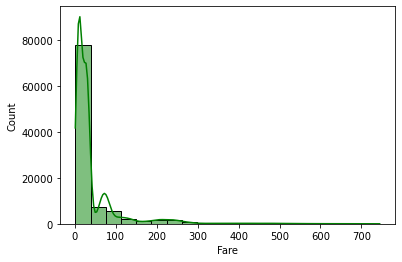

In [189]:
sns.histplot(x=train_df['Fare'], bins=20, kde=True, color='g')

In [190]:
train_df['SibSp'].value_counts()

0    73308
1    19758
2     3703
3     1635
4     1168
8      296
5      132
Name: SibSp, dtype: int64

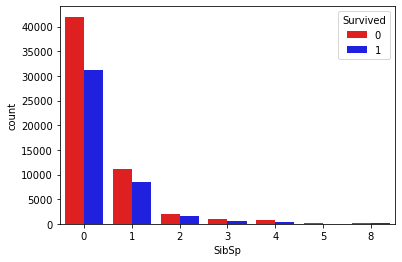

In [191]:
sns.countplot(data=train_df, x='SibSp', hue='Survived', palette=['red', 'blue']);

In [192]:
train_df['Parch'].value_counts()

0    73540
1    12996
2    11236
3      983
4      446
5      331
9      264
6      204
Name: Parch, dtype: int64

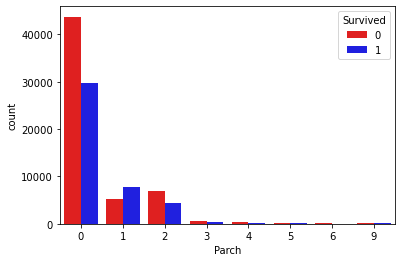

In [193]:
sns.countplot(data=train_df, x='Parch', hue='Survived', palette=['red', 'blue']);

# Data Processing

- Member: create new feature which is the count of family number
- Age: Fill N/A with mean of grouping by number of member Family
- Fare: Fill NA with median of grouping by Ticket class, take the log to regularize outlier
- Cabin, fillna with 'N' and take first letter
- Ticket, fillna with 'X', split string and take first split
- Embarked, fillna with 'N' value

In [194]:
fare_map = train_df[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
train_df['Fare'] = train_df['Fare'].fillna(train_df['Pclass'].map(fare_map['Fare']))
train_df['Fare'] = np.log(train_df['Fare'])
test_df['Fare'] = test_df['Fare'].fillna(test_df['Pclass'].map(fare_map['Fare']))
test_df['Fare'] = np.log(test_df['Fare'])

In [195]:
train_df['Member'] = train_df['SibSp'] + train_df['Parch'] +1
test_df['Member'] = test_df['SibSp'] + test_df['Parch'] + 1

In [196]:
age_map = train_df[['Age', 'Member']].dropna().groupby('Member').median().to_dict()
train_df['Age'] = train_df['Age'].fillna(train_df['Member'].map(age_map['Age']))
test_df['Age'] = test_df['Age'].fillna(test_df['Member'].map(age_map['Age']))
#train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
#test_df['Age'] = test_df['Age'].fillna(train_df['Age'].mean())

In [197]:
train_df['Cabin'] = train_df['Cabin'].fillna('N').map(lambda x: x[0].strip())
test_df['Cabin'] = test_df['Cabin'].fillna('N').map(lambda x: x[0].strip())

In [198]:
train_df['Ticket'] = train_df['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')
test_df['Ticket'] = test_df['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

In [199]:
train_df['Embarked'] = train_df['Embarked'].fillna('N')
test_df['Embarked'] = test_df['Embarked'].fillna('N')

In [200]:
label_col = ['Pclass', 'Sex', 'Cabin', 'Embarked','Ticket']

lc = LabelEncoder()
for col in label_col:
    train_df[col] = lc.fit_transform(train_df[col])
    test_df[col] = lc.transform(test_df[col])

In [208]:
features = ['Age','Fare','Pclass', 'Sex', 'Embarked','Ticket','Member']
sc = StandardScaler()
train_df[features] = sc.fit_transform(train_df[features])
test_df[features] = sc.transform(test_df[features])

### Tuning parameters

In [209]:
train = train_df[features]
test = test_df[features]
target = train_df['Survived']
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size= 0.2)

In [210]:
param_grid = {"C":np.logspace(-3,3,7), "max_iter": np.linspace(100,500,10)} 
logreg = LogisticRegression()
grid_search = GridSearchCV(logreg,param_grid,cv=10,n_jobs=10)
grid_search.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'max_iter': 100.0}
accuracy : 0.7692125


In [211]:
logit_clf = LogisticRegression(C=0.001,max_iter=100).fit(X_train, y_train)
logit_clf.score(X_val, y_val)

0.7662

In [214]:
param_grid = [
        {'kernel': ['rbf'], 'C': [1.0, 3.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0]},
    ]

svm_reg = SVC()
grid_search = GridSearchCV(svm_reg, param_grid, cv=3, scoring='accuracy', verbose=2,n_jobs=10)
grid_search.fit(X_train,y_train)
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed: 20.1min remaining:  2.2min
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 21.3min finished


tuned hpyerparameters :(best parameters)  {'C': 3.0, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy : 0.7723250174290693


In [219]:
svm_clf = SVC(C=3.0,gamma=0.1,kernel='rbf',probability=True).fit(X_train, y_train)
svm_clf.score(X_val, y_val)

0.7705

In [216]:
param_grid = [
    {'n_estimators': [100, 200, 300,400,500],'max_depth': [40,60,80], 'min_samples_split': [30,40,50], 'min_samples_leaf': [20,30,40]}
  ]

forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(forest_clf, param_grid, cv=3,scoring='accuracy',n_jobs=10)
grid_search.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 40, 'min_samples_leaf': 20, 'min_samples_split': 30, 'n_estimators': 500}
accuracy : 0.7753249986797726


In [220]:
forest_clf = RandomForestClassifier(max_depth=40,min_samples_leaf=20,min_samples_split=30,n_estimators=500).fit(X_train, y_train)
forest_clf.score(X_val, y_val)

0.76905

In [224]:
param_grid = [
    {'metric': ["binary_logloss"],'n_estimators':[1200],'objective': ['binary'],
     'learning_rate':[0.01,0.05,0.1],'reg_lambda': [2.2,2.343120757686286,2.4],'reg_alpha': [9.9,9.978349316502767,10.1],
     'colsample_bytree': [0.3,0.4,0.5],
      'min_child_samples': [300],'max_depth': [50,60,70,80,90],'num_leaves': [30,40,50,60,70]}]

lgbm_clf = LGBMClassifier()
grid_search = GridSearchCV(lgbm_clf, param_grid, cv=3,scoring='accuracy',n_jobs=10)
grid_search.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 50, 'metric': 'binary_logloss', 'min_child_samples': 300, 'n_estimators': 1200, 'num_leaves': 30, 'objective': 'binary', 'reg_alpha': 9.978349316502767, 'reg_lambda': 2.4}
accuracy : 0.7751874999297451


In [225]:
params = {
    'metric': 'binary_logloss',
    'n_estimators': 12000,
    'objective': 'binary',
    'learning_rate': 0.01,
    'reg_lambda': 2.4,
    'reg_alpha': 9.978349316502767,
    'colsample_bytree': 0.5,
    'min_child_samples': 300,
    'max_depth': 50,
    'num_leaves': 30,
}
lgbm_clf = LGBMClassifier(**params).fit(X_train, y_train)
lgbm_clf.score(X_val, y_val)

0.7716

In [226]:
voting_clf = VotingClassifier(
    estimators=[('lr', logit_clf),('svm',svm_clf), ('fr',forest_clf),('lgbm',lgbm_clf)],
    voting='soft').fit(X_train, y_train)

In [227]:
voting_clf.score(X_val, y_val)

0.77035

In [228]:
y_pred = voting_clf.predict(test)

In [229]:
submission = pd.DataFrame({
        "PassengerId": test_df['PassengerId'],
        "Survived": y_pred
    })

submission.to_csv('../output/submission_april_2021.csv', index=False)

In [159]:
train_df['Name']

0          Oconnor, Frankie
1               Bryan, Drew
2            Owens, Kenneth
3             Kramer, James
4             Bond, Michael
                ...        
99995           Bell, Adele
99996         Brown, Herman
99997    Childress, Charles
99998      Caughlin, Thomas
99999         Enciso, Tyler
Name: Name, Length: 100000, dtype: object

In [161]:
train_df[['Name', 'Age']][0:100]

,Name,Age
0,"Oconnor, Frankie",-0.075172
1,"Bryan, Drew",0.035811
2,"Owens, Kenneth",-2.110039
3,"Kramer, James",-1.074016
4,"Bond, Michael",-0.741068
...,...,...
95,"Gruska, Karen",0.812690
96,"Jordan, Emma",-0.574594
97,"Elliott, Monica",0.979164
98,"Bohn, Teresa",-1.684421
